# Optional Question
Focus on the trip data during 2019-01 and 2019-12 only. Now, the client of MSBA & Company wants to understand the key factors that explains the difference in the (average daily) ridership between different pairs of origin and destination. Please explore auxiliary data sets and discuss your findings. [3pts]

As for this problem, there are several categories of factors that will affect the daily average number of riders for a specific routine(Origin-destination pair).
 - Information only related to start/end location 
    - Geographic information
         - Latitude
         - Longitude
         - District
    - Infrastructure information
        - Total docks
    - Traffic information
        - Rider gender distribution
        - Direction distribution(Identify most riderships are ride in or ride out?)
        - Peak hour(Identify the busiest time of the place)
        - Standard deviation of daily number(Identify the location's service is rigid demand or elastic demand.)
 - Features related to both locations
    - Geographic distance
        - Distance between two stations
        - Whether the two sites are cross-regional
    - Positioning distance
        - Gender distribution distance
        - Direction distribution distance
        - Peak hour distance
        - Standard deviation distance
        - Dock number gap

In [1]:
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append(
    r'D:\OneDrive\Programming\documents_python\NUS Courses\DBA5106\Course-DBA5106\assignment\IndividualAssignment2')

In [3]:
from utils.logger import logger
from utils.config import PROCESSED_DATA_DIR
from utils.data_porter import read_from_csv

## Data Cleaning

In [4]:
# Set hyper parameter
START_DATE = '2019-01-01'
END_DATE = '2019-12-31'

In [5]:
# Prepare the trip data
tripdata_df = read_from_csv('tripdata.csv', PROCESSED_DATA_DIR,
                            parse_dates=['starttime', 'stoptime'])
tripdata_df['datetime'] = tripdata_df['starttime'].dt.strftime("%Y-%m-%d")
tripdata_used = tripdata_df.loc[(tripdata_df['datetime'] >= START_DATE) &
                                (tripdata_df['datetime'] <= END_DATE)]

In [6]:
# Prepare the station info
station_info = read_from_csv('Stations.csv', PROCESSED_DATA_DIR)
station_info['District'].value_counts()

# create usertype map(remain usertype id in the main file)
district_dict = {'Boston': 1, 'Cambridge': 2,'Somerville': 3, 
                 'Brookline': 4, 'Everett': 5}
station_info['district_id'] = station_info['District'].map(district_dict)

# Drop unrelated columns
drop_lst = ['Name', 'District', 'Public']
station_info.drop(drop_lst, axis=1, inplace=True)

print(station_info.head())

   Station Id   Latitude  Longitude  Total docks  district_id
0         149  42.363796 -71.129164           18            1
1         378  42.380323 -71.108786           19            3
2         330  42.381001 -71.104025           15            3
3         116  42.370803 -71.104412           23            2
4         333  42.375002 -71.148716           25            2


In [7]:
# Ignore the trips that station id is not in the station information file
station_lst = station_info['Station Id'].tolist()
tripdata_cleaned = tripdata_used.loc[(tripdata_used['start station id'].isin(station_lst)) &
                                     (tripdata_used['end station id'].isin(station_lst))]
tripdata_cleaned.dtypes

tripduration                 int64
starttime           datetime64[ns]
stoptime            datetime64[ns]
start station id             int64
end station id               int64
bikeid                       int64
birth year                   int64
gender                     float64
usertype_id                  int64
datetime                    object
dtype: object

In [8]:
# To silence the Warning
pd.set_option('mode.chained_assignment', None)

# Creat unique id for a origin-destiney pair
tripdata_cleaned['od_pair'] = tripdata_cleaned.apply(
    lambda x: str(x['start station id']) + '_' + str(x['end station id']), axis=1)

In [9]:
tripdata_cleaned.head(2)

,tripduration,starttime,stoptime,start station id,end station id,bikeid,birth year,gender,usertype_id,datetime,od_pair
5212224,371,2019-01-01 00:09:13.798,2019-01-01 00:15:25.336,80,179,3689,1987,1.0,1,2019-01-01,80_179
5212225,264,2019-01-01 00:33:56.182,2019-01-01 00:38:20.880,117,189,4142,1990,1.0,1,2019-01-01,117_189


In [10]:
od_pair = tripdata_cleaned['od_pair'].value_counts().sort_index()/365

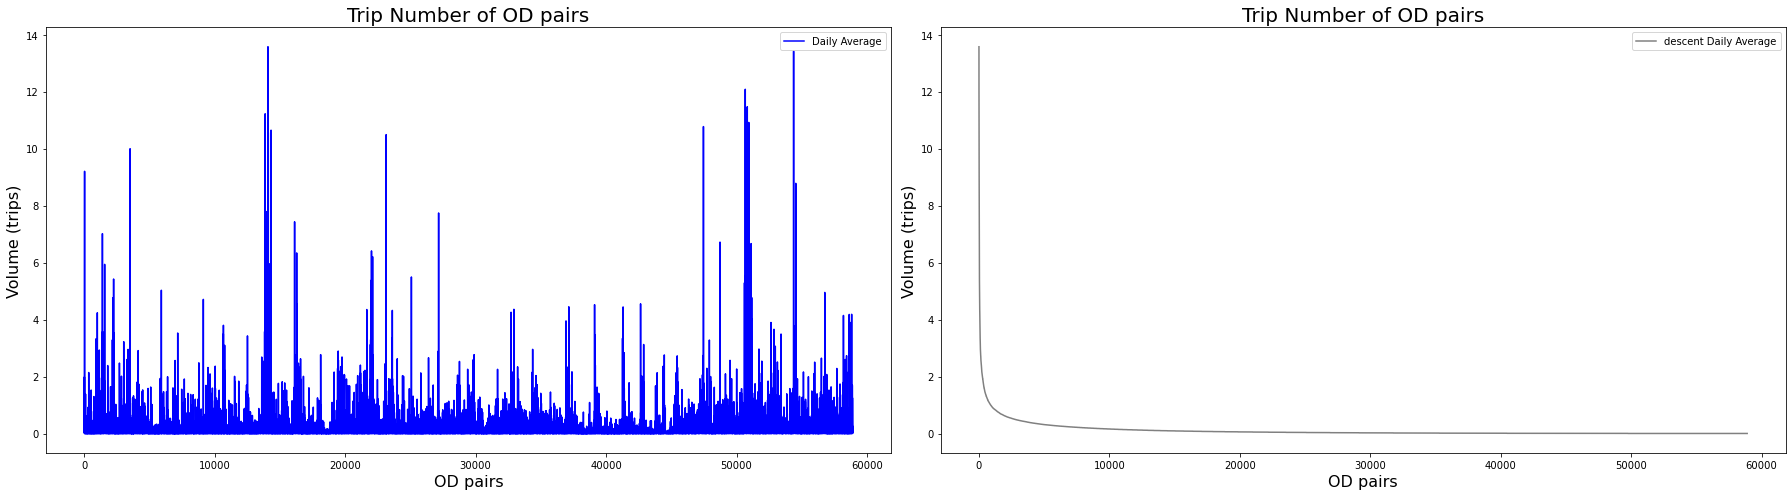

In [11]:
fig = plt.figure(figsize=(25, 7))
ax1 = plt.subplot(121)
ax1.plot(od_pair.tolist(), color='blue', label='Daily Average')
ax1.set_xlabel('OD pairs', fontsize=16)
ax1.set_ylabel('Volume (trips)', fontsize=16)
ax1.set_title(f'Trip Number of OD pairs', fontsize=20)
ax1.legend(loc='upper right')

ax2 = plt.subplot(122)
ax2.plot(od_pair.sort_values(ascending=False).tolist(),color='Grey', label='descent Daily Average')
ax2.set_xlabel('OD pairs', fontsize=16)
ax2.set_ylabel('Volume (trips)', fontsize=16)
ax2.set_title(f'Trip Number of OD pairs', fontsize=20)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Feature Engineering

### Feature Engineering -- Traffic information

 - Information only related to start/end location 
    - Traffic information
        - Daily Average Trips
        - Daily Average Ride In Trips
        - Daily Average Ride Out Trips
        - Rider gender distribution
        - Direction distribution(Identify most riderships are ride in or ride out?)
        - Peak hour(Identify the busiest time of the place)
        - Standard deviation of daily number(Identify the location's service is rigid demand or elastic demand.)

In [12]:
def calcu_stat(station_id, stat):
    """calculate the station statistic information"""
    data_selected = tripdata_cleaned.loc[(tripdata_cleaned['start station id'] == station_id) |
                                         (tripdata_cleaned['end station id'] == station_id)]
    if stat == 'trip_num':
        return(len(data_selected))
    elif stat == 'ride_in_num':
        return(len(data_selected.loc[(tripdata_cleaned['end station id'] == station_id)]))
    elif stat == 'ride_out_num':
        return(len(data_selected.loc[(tripdata_cleaned['start station id'] == station_id)]))
    elif stat == 'ride_in_ratio':
        trip_num = len(data_selected)
        ride_in_num = len(
            data_selected.loc[(tripdata_cleaned['end station id'] == station_id)])
        return(ride_in_num/trip_num)
    elif stat == 'gender_ratio':
        gender_ratio = len(
            data_selected.loc[(tripdata_cleaned['gender'] == 1)])/len(
            data_selected.loc[(tripdata_cleaned['gender'] == 0)])
        return(gender_ratio)
    elif stat == 'sd':
        return(data_selected['datetime'].value_counts().std())
    elif stat == 'ring_route_ratio':
        trip_num = len(data_selected)
        ring_route_num = len(
            tripdata_cleaned.loc[(tripdata_cleaned['start station id'] == station_id) &
                                 (tripdata_cleaned['end station id'] == station_id)])
        return(ring_route_num/trip_num)
    else:
        raise Exception

In [13]:
station_info.head(2)

,Station Id,Latitude,Longitude,Total docks,district_id
0,149,42.363796,-71.129164,18,1
1,378,42.380323,-71.108786,19,3


In [14]:
station_info['trip_num'] = station_info['Station Id'].apply(
    lambda x: calcu_stat(x, stat='trip_num'))
station_info['ride_in_num'] = station_info['Station Id'].apply(
    lambda x: calcu_stat(x, stat='ride_in_num'))
station_info['ride_out_num'] = station_info['Station Id'].apply(
    lambda x: calcu_stat(x, stat='ride_out_num'))
station_info['ride_in_ratio'] = station_info['Station Id'].apply(
    lambda x: calcu_stat(x, stat='ride_in_ratio'))
station_info['gender_ratio'] = station_info['Station Id'].apply(
    lambda x: calcu_stat(x, stat='gender_ratio'))
station_info['sd'] = station_info['Station Id'].apply(
    lambda x: calcu_stat(x, stat='sd'))
station_info['ring_route_ratio'] = station_info['Station Id'].apply(
    lambda x: calcu_stat(x, stat='ring_route_ratio'))
station_info['ring_route_ratio'] = station_info['Station Id'].apply(
    lambda x: calcu_stat(x, stat='ring_route_ratio'))
print('The statistical characteristics of the station are processed')

The statistical characteristics of the station are processed


In [15]:
station_info.head(2)

,Station Id,Latitude,Longitude,Total docks,district_id,trip_num,ride_in_num,ride_out_num,ride_in_ratio,gender_ratio,sd,ring_route_ratio
0,149,42.363796,-71.129164,18,1,22081,11429,11144,0.517594,4.736295,36.722545,0.022282
1,378,42.380323,-71.108786,19,3,10880,5364,5605,0.493015,7.928894,14.747012,0.008180


### Feature Engineering -- Others related to start/end location

In [16]:
dataset = pd.DataFrame(od_pair)
dataset.reset_index(inplace=True)
dataset.columns = ['od_pair', 'y_true']

In [17]:
dataset['original_id'] = dataset['od_pair'].apply(lambda x: int(x.split("_")[0]))
dataset['destination_id'] = dataset['od_pair'].apply(lambda x: int(x.split("_")[1]))
dataset.head(2)

,od_pair,y_true,original_id,destination_id
0,100_10,0.112329,100,10
1,100_100,1.986301,100,100


In [18]:
dataset = pd.merge(left=dataset, right=station_info,
                   how='left', left_on='original_id', right_on='Station Id')
dataset = pd.merge(left=dataset, right=station_info,
                   how='left', left_on='destination_id', right_on='Station Id', suffixes=['_o', '_d'])

### Feature Engineering -- Others related to both

 - Features related to both locations
    - Geographic distance
        - Distance between two stations
        - Whether the two sites are cross-regional
    - Positioning distance
        - Gender distribution distance
        - Direction distribution distance
        - Peak hour distance
        - Standard deviation distance
        - Dock number gap

In [19]:
dataset.head(2)

,od_pair,y_true,original_id,destination_id,Station Id_o,Latitude_o,Longitude_o,Total docks_o,district_id_o,trip_num_o,...,Longitude_d,Total docks_d,district_id_d,trip_num_d,ride_in_num_d,ride_out_num_d,ride_in_ratio_d,gender_ratio_d,sd_d,ring_route_ratio_d
0,100_10,0.112329,100,10,100,42.396969,-71.123024,25,3,30597,...,-71.108279,11,1,33897,17316,17181,0.510842,6.754360,55.949996,0.017701
1,100_100,1.986301,100,100,100,42.396969,-71.123024,25,3,30597,...,-71.123024,25,3,30597,16707,14615,0.546034,5.358989,40.135713,0.023695


In [20]:
from math import radians, cos, sin, asin, sqrt
 
def haversine(lon1, lat1, lon2, lat2): # Longitude 1, Latitude 1, Longitude 2, Latitude 2 (decimal number)
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert the decimal number into radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # The average radius of the earth (kilometers)
    return c * r * 1000

In [21]:
dataset['geographic_distance'] = dataset.apply(
    lambda x: haversine(x['Longitude_o'], x['Latitude_o'], 
                        x['Longitude_d'], x['Latitude_d']), axis=1)

In [22]:
# Whether the two sites are cross-regional
dataset['cross_regional'] = dataset.apply(
    lambda x: 0 if x['district_id_o'] == x['district_id_d'] else 1, axis=1)

In [23]:
# Direction distribution distance
dataset['direction_distribution_distance'] = dataset.apply(
    lambda x: abs(x['ride_in_ratio_o'] - x['ride_in_ratio_d']), axis=1)

In [24]:
# Standard deviation distance
dataset['sd_distance'] = dataset.apply(
    lambda x: abs(x['sd_o'] - x['sd_d']), axis=1)

# Mean value of the Standard deviation of two stations
dataset['sd_mean'] = dataset.apply(
    lambda x: (x['sd_o'] + x['sd_d'])/2, axis=1)

In [25]:
# Dock number gap
dataset['dock_num_gap'] = dataset.apply(
    lambda x: abs(x['Total docks_o'] - x['Total docks_d']), axis=1)

# Mean value of the number of Dock number at two stations
dataset['dock_num_mean'] = dataset.apply(
    lambda x: (x['Total docks_o'] + x['Total docks_d'])/2, axis=1)

In [26]:
# Mean value of the daily average trip number of two stations
dataset['trip_num_mean'] = dataset.apply(
    lambda x: (x['trip_num_o'] + x['trip_num_d'])/2, axis=1)

In [27]:
dataset.head(2)

,od_pair,y_true,original_id,destination_id,Station Id_o,Latitude_o,Longitude_o,Total docks_o,district_id_o,trip_num_o,...,sd_d,ring_route_ratio_d,geographic_distance,cross_regional,direction_distribution_distance,sd_distance,sd_mean,dock_num_gap,dock_num_mean,trip_num_mean
0,100_10,0.112329,100,10,100,42.396969,-71.123024,25,3,30597,...,55.949996,0.017701,5317.364565,1,0.035192,15.814283,48.042854,14,18.0,32247.0
1,100_100,1.986301,100,100,100,42.396969,-71.123024,25,3,30597,...,40.135713,0.023695,0.000000,0,0.000000,0.000000,40.135713,0,25.0,30597.0


## Multiple Linear Regression

In [28]:
# Delete irrelevant items
drop_lst = ['od_pair', 'original_id', 'destination_id', 'Station Id_o', 'Station Id_d']
dataset = dataset.drop(drop_lst, axis=1)

# Data description
dataset.describe().head(2)

,y_true,Latitude_o,Longitude_o,Total docks_o,district_id_o,trip_num_o,ride_in_num_o,ride_out_num_o,ride_in_ratio_o,gender_ratio_o,...,sd_d,ring_route_ratio_d,geographic_distance,cross_regional,direction_distribution_distance,sd_distance,sd_mean,dock_num_gap,dock_num_mean,trip_num_mean
count,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000,...,58895.000000,58895.00000,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000
mean,0.114028,42.354334,-71.089136,18.192139,1.571594,19647.679073,9995.761474,9980.825011,0.510624,6.789064,...,31.791055,0.02626,3814.449189,0.487614,0.032378,27.219594,32.035115,4.231921,18.182197,19494.550276


In [29]:
# Missing value test
dataset[dataset.isnull()==True].count()

y_true                             0
Latitude_o                         0
Longitude_o                        0
Total docks_o                      0
district_id_o                      0
trip_num_o                         0
ride_in_num_o                      0
ride_out_num_o                     0
ride_in_ratio_o                    0
gender_ratio_o                     0
sd_o                               0
ring_route_ratio_o                 0
Latitude_d                         0
Longitude_d                        0
Total docks_d                      0
district_id_d                      0
trip_num_d                         0
ride_in_num_d                      0
ride_out_num_d                     0
ride_in_ratio_d                    0
gender_ratio_d                     0
sd_d                               0
ring_route_ratio_d                 0
geographic_distance                0
cross_regional                     0
direction_distribution_distance    0
sd_distance                        0
s

In [30]:
# Normalized
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
dataset_scale = scaler.fit_transform(dataset)
dataset_scale = pd.DataFrame(dataset_scale)
dataset_scale.columns = dataset.columns

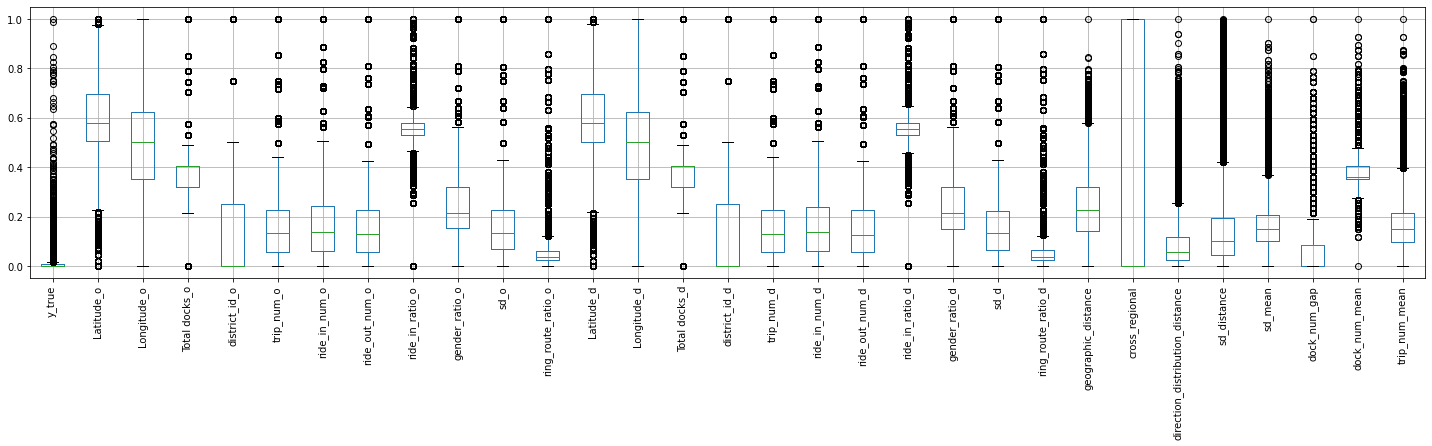

In [31]:
dataset_scale.boxplot(figsize=(25, 5))
plt.xticks(rotation=90)
plt.show()

In [32]:
# Correlation coefficient r(correlation coefficient) = cov(x,y) / σx * σy
# 0 ~ 0.3 weak correlation 
# 0.3 ~ 0.6 moderate correlation 
# 0.6 ~ 1 strong correlation
dataset_scale.corr()['y_true']

y_true                             1.000000
Latitude_o                         0.042615
Longitude_o                        0.016018
Total docks_o                      0.118151
district_id_o                     -0.014742
trip_num_o                         0.258691
ride_in_num_o                      0.256800
ride_out_num_o                     0.259586
ride_in_ratio_o                   -0.021724
gender_ratio_o                     0.098052
sd_o                               0.243486
ring_route_ratio_o                -0.069837
Latitude_d                         0.044523
Longitude_d                        0.020615
Total docks_d                      0.119359
district_id_d                     -0.019031
trip_num_d                         0.265761
ride_in_num_d                      0.266196
ride_out_num_d                     0.264367
ride_in_ratio_d                   -0.011715
gender_ratio_d                     0.096069
sd_d                               0.255302
ring_route_ratio_d              

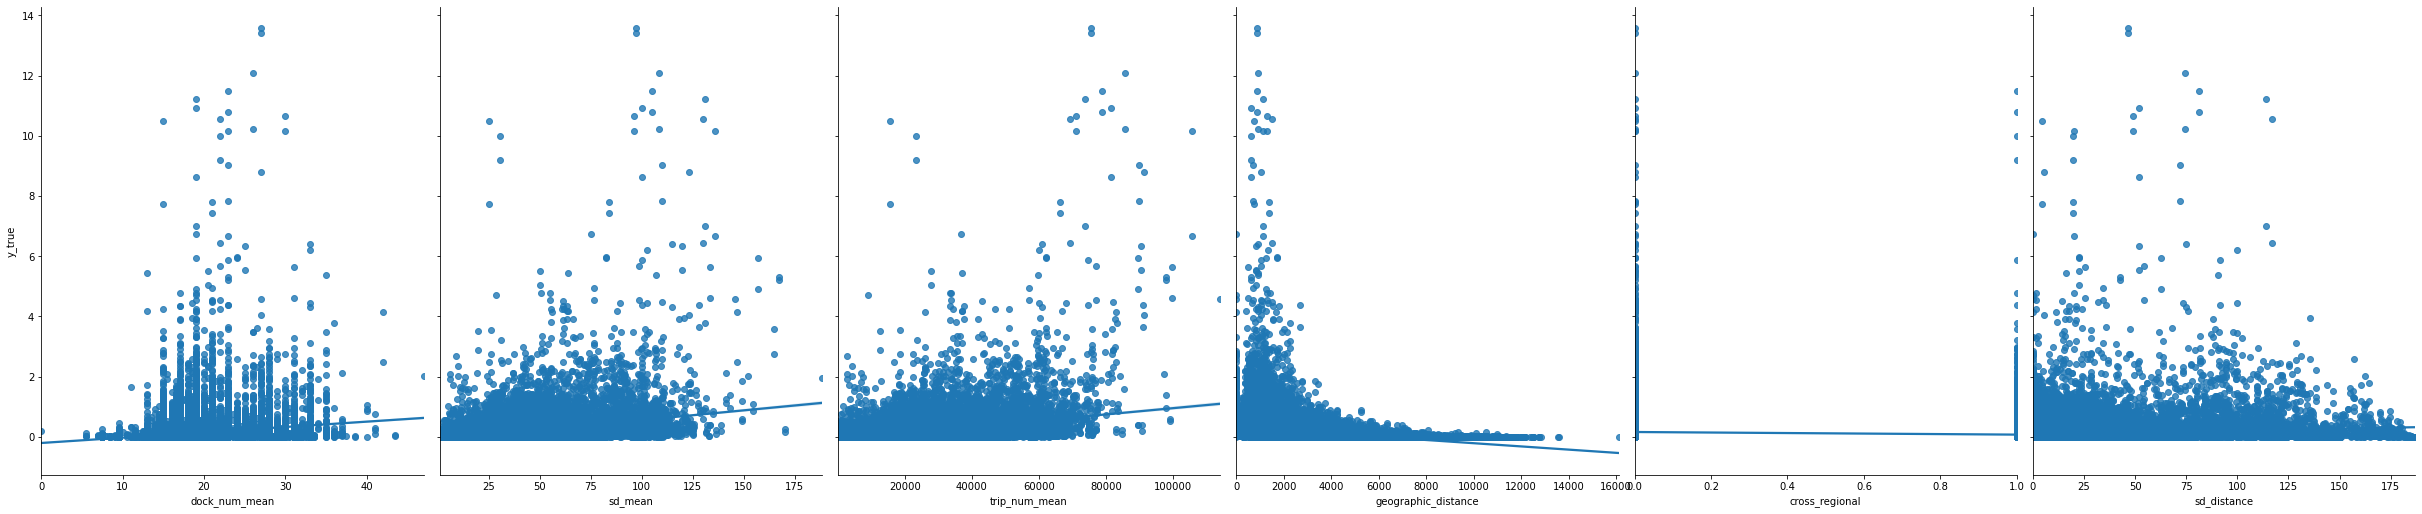

In [33]:
# By adding a parameter kind='reg', seaborn can add a best-fitting line and a 95% confidence band.
import seaborn as sns

sns.pairplot(dataset, x_vars=['dock_num_mean', 'sd_mean', 'trip_num_mean', 'geographic_distance', 'cross_regional', 'sd_distance'],
             y_vars='y_true', height=7, aspect=0.8, kind='reg')
plt.savefig("pairplot.jpg")
plt.show()

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

variable_list = dataset_scale.columns
variable_list = variable_list.drop('y_true')

X_train,X_test,Y_train,Y_test = train_test_split(dataset_scale[variable_list],dataset['y_true'],train_size=.80)

LR_model = LinearRegression()
 
LR_model.fit(X_train,Y_train)
 
a  = LR_model.intercept_ # intercept
 
b = LR_model.coef_ # Regression coefficients

print('Intercept: ', a)
print('Regression coefficients: ', b)

Intercept:  0.11918771603885987
Regression coefficients:  [-0.00612002 -0.079795    0.05314028  0.12323747  4.09131361 -2.74717387
 -2.74046716 -0.09322651 -0.02084284  0.31001354  0.26779192 -0.02077072
 -0.07973744  0.04479086  0.12594168  3.67567938 -2.02063789 -3.07531934
 -0.05118046 -0.01967976  0.30604996  0.26008544 -0.50784653 -0.13626559
  0.03787919 -0.67083899  0.30803175 -0.05096877  0.04896557  3.88349649]


In [35]:
score = LR_model.score(X_train, Y_train)
print(score)

0.25955021485518937


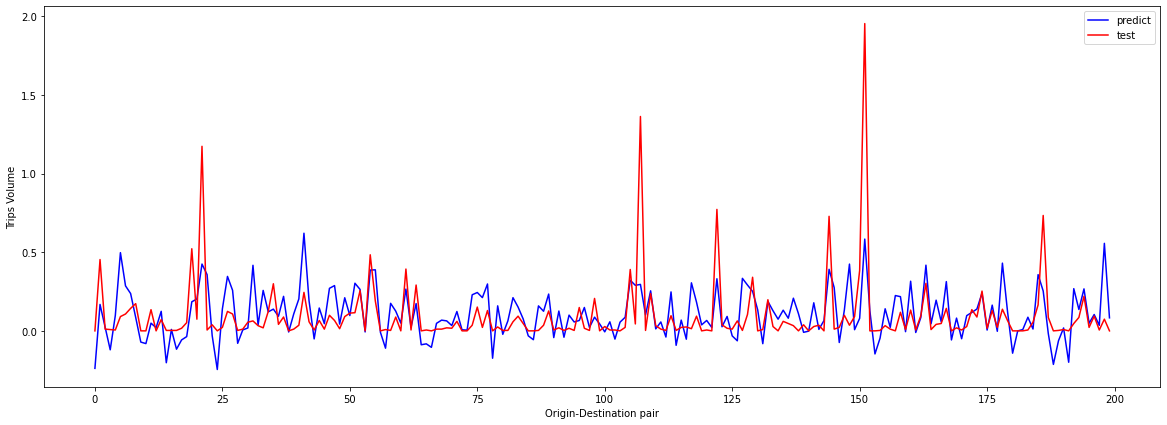

In [36]:
Y_pred = LR_model.predict(X_test)
plt.figure(figsize=(20,7))
plt.plot(range(len(Y_pred[:200])),Y_pred[:200],'b',label="predict")
plt.plot(range(len(Y_pred[:200])),Y_test[:200],'r',label="test")
plt.legend(loc="upper right")
plt.xlabel("Origin-Destination pair")
plt.ylabel('Trips Volume')
plt.show()

 - The final R-square of the model is 0.26. 
 - In real life, this model can only explain a part of the trip number of a Origin-Destiny pair.
 - It also means that there are many variables that we have not taked into consideration.
 - Varibles that contribute to the model:
     - 'dock_num_mean': Mean value of the dock number of the od pair
     - 'sd_mean': Mean value of the Demand Elasticity(Standard Deviation) of the od pair
     - 'trip_num_mean': Mean value of the daily average trip number of the od pair
     - 'geographic_distance': Geographical distance between two stations
     - 'cross_regional': Whether the two stations are cross-regional
     - 'sd_distance': The difference in demand elasticity between the two stations
 - For improvement(neglected features):
     - Date information of sports games held in Boston(such as Boston Celtics Basketball Team)
     - Calendar of Boston Schools(Stanford/MIT)